In [1]:
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn
import re
import tensorflow as tf

In [2]:
import math
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, RNN, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [7]:
seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [8]:
df = pd.read_csv("https://raw.githubusercontent.com/ammaarahmad1999/Time_Series_Dataset/main/bbc.csv", index_col=0)

In [9]:
label_dict = {'business': 0, 'entertainment' : 1, 'politics' : 2, 'sport' : 3, 'tech' : 4}

In [10]:
df['labels'] = df['Class'].replace(label_dict)

In [11]:
vocabulary = set()

In [12]:
accuracy_models = dict()

#Data Preprocessing

In [13]:
def cleaning(text):
  line = re.sub('[^A-Za-z0-9]+', ' ', text)
  tokens = line.split()
  tokens = [w for w in tokens if not w.lower() in STOPWORDS]
  text = " ".join(tokens)
  for word in tokens:
    vocabulary.add(word)
  return text
def length(text):
  return len(text.split())
df['text'] = df['Article'].apply(cleaning)
df['length'] = df['text'].apply(length)

In [14]:
df = df.sample(frac = 1, random_state = 1)

In [15]:
df.reset_index(drop = True, inplace = True)

In [16]:
df

,Article,Class,labels,text,length
0,Cactus diet deal for Phytopharm\n\nA slimming ...,business,0,Cactus diet deal Phytopharm slimming aid made ...,143
1,Winter freeze keeps oil above $50\n\nOil price...,business,0,Winter freeze keeps oil 50 Oil prices carried ...,201
2,Mobiles rack up 20 years of use\n\nMobile phon...,tech,4,Mobiles rack 20 years use Mobile phones UK cel...,255
3,Giving financial gifts to children\n\nYour chi...,business,0,Giving financial gifts children child grandchi...,436
4,Bank payout to Pinochet victims\n\nA US bank h...,business,0,Bank payout Pinochet victims US bank said dona...,184
...,...,...,...,...,...
1907,Crucial decision on super-casinos\n\nA decisio...,politics,2,Crucial decision super casinos decision whethe...,108
1908,Cyber crime booms in 2004\n\nThe last 12 month...,tech,4,Cyber crime booms 2004 last 12 months seen dra...,471
1909,Howard rejects BNP's claim\n\nTory leader Mich...,politics,2,Howard rejects BNP claim Tory leader Michael H...,184
1910,Card fraudsters 'targeting web'\n\nNew safegua...,business,0,Card fraudsters targeting web New safeguards c...,248


In [17]:
vocab_size = len(vocabulary)
embedding_dim = 100
max_length = 512
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [18]:
train_size = math.ceil(0.7 * len(df))
valid_size = math.ceil(0.8 * len(df))

In [19]:
df_test = df[valid_size:]
df_test.to_csv("Test_Data.csv", index = None)

In [20]:
X_train = df['text'][0:train_size]
X_valid = df['text'][train_size:valid_size]
X_test  = df['text'][valid_size:]
Y_train = pd.get_dummies(df['labels'][0:train_size]).values
Y_valid = pd.get_dummies(df['labels'][train_size:valid_size]).values
Y_test  = pd.get_dummies(df['labels'][valid_size:]).values

In [21]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [22]:
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
X_train = pad_sequences(X_train, maxlen=max_length)
X_valid = pad_sequences(X_valid, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [24]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df['Class'])

#Vanilla RNN

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.SimpleRNN(256, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3129000   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 256)         91392     
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [27]:
num_epochs = 5
history = model.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 79s 462ms/step - loss: 1.5687 - accuracy: 0.2591 - val_loss: 1.5673 - val_accuracy: 0.2513
Epoch 2/5
168/168 [==============================] - 77s 460ms/step - loss: 20654.3926 - accuracy: 0.3174 - val_loss: 1.5788 - val_accuracy: 0.2094
Epoch 3/5
168/168 [==============================] - 78s 462ms/step - loss: 1.6136 - accuracy: 0.4070 - val_loss: 1.4910 - val_accuracy: 0.3246
Epoch 4/5
168/168 [==============================] - 77s 460ms/step - loss: 0.9225 - accuracy: 0.6363 - val_loss: 1.2409 - val_accuracy: 0.5340
Epoch 5/5
168/168 [==============================] - 77s 460ms/step - loss: 0.4979 - accuracy: 0.8133 - val_loss: 1.4177 - val_accuracy: 0.4921


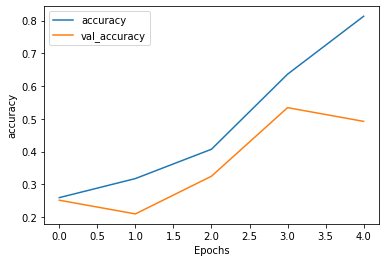

In [28]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")

In [29]:
test_loss, accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, accuracy))

12/12 [==============================] - 2s 153ms/step - loss: 1.4727 - accuracy: 0.5209
Test set
  Loss: 1.473
  Accuracy: 0.521


In [31]:
prediction_rnn = model.predict(X_test)
prediction_rnn = np.argmax(prediction_rnn, axis = 1)
df_test['prediction_rnn'] = prediction_rnn
df_test.to_csv("Test_Results_RNN.csv", index = None)

In [32]:
accuracy = accuracy_score(df_test['labels'], prediction_rnn)
accuracy_models['RNN'] = accuracy
print(f'Accuracy of RNN = {accuracy}')
print(classification_report(df_test['labels'], prediction_rnn))

Accuracy of RNN = 0.5209424083769634
              precision    recall  f1-score   support

           0       0.78      0.56      0.65        93
           1       0.38      0.83      0.53        76
           2       0.44      0.48      0.46        82
           3       0.11      0.02      0.04        42
           4       0.81      0.49      0.62        89

    accuracy                           0.52       382
   macro avg       0.51      0.48      0.46       382
weighted avg       0.56      0.52      0.51       382



In [ ]:
model.save_weights("rnn_model.h5")